In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_across_time_bins_FIGURES'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end
pl.rcParams['pdf.fonttype']=42
pl.rcParams['ps.fonttype']=42

In [5]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [6]:
def report_stats (array1, array2, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
        U = sig_func(array1, array2)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        p = sig_func(array1, array2)[-1]
        print "U =",U,"p =",p*mcc,"r =",r
    if sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_ind(x, y)
        cohens_d = (np.mean(array1)-np.mean(array2))/np.sqrt((np.std(array1)**2+np.std(array2)**2)/2)
        p = sig_func(array1, array2)[-1]
        print sig_func(array1, array2),"d =", cohens_d, 'corrected p =',p*mcc

def report_stats_chance (array1, chance=0.5, sig_func=None,mcc=1):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        U = sig_func(subtracted)[0]
        z = ((U-((loops*loops)/2))/(np.sqrt(((loops*loops)*(loops+loops+1))/12)))
        r = z/np.sqrt(loops*2)
        print sig_func(subtracted),"r =",r
    elif sig_func is 'ttest':
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        cohens_d = (np.mean(array1)-chance)/np.std(array1)
        print sig_func(array1,chance),"d =",cohens_d

In [7]:
#mmc = multiple-comparisons correction (using bonferroni), where mcc = number of comparisons))

from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),mcc=1):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'p=%.2f'%(p/mcc) if .1>p>.05 else
            'n.s.' if p > thresholds[0]/mcc else
            '*' if p > thresholds[1]/mcc else
            '**' if p > thresholds[2]/mcc else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [8]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [9]:
def add_2way_sig(ax, sess, epoch, x, y, thresholds=(0.05, 0.01, 0.001)):
    p_reg = eval("%s_%s_pvals['region'][0]"%(epoch,sess))
    p_per = eval("%s_%s_pvals['period'][0]"%(epoch,sess))
    p_interac = eval("%s_%s_pvals['interaction'][0]"%(epoch,sess))
    for tex,i,ps in zip(('region','period','r X p   '),(8,4,0),(p_reg,p_per,p_interac)):
        ax.text(x, y+i, tex+': '+
            ('n.s.' if ps>thresholds[0] else
            '*' if ps>thresholds[1] else
            '**' if ps>thresholds[2] else
            '***'),
            ha='left', fontsize=3.5)
    return p

In [10]:
sessions = 'expo', 'pre', 'post','post_hiatus'
session_labels = ('Pre','Early','Late','Post')
comparisons = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
comp_labels = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-']
comp_colors = ['r','dodgerblue','limegreen', '#7201a8', '#bd3786', '#ed7953', '#fdca26']
tt_colors = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','dodgerblue']
tt_colors_k = ['#7201a8', '#bd3786', '#ed7953', '#fdca26','k']
alt_comparisons = ['CSPvsCSM_averaged','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4']
alt_colors=['#003f5c','#bc5090','#ffa600']
alt2_colors=['#15345c','#90488b','#ff6072']
dark_co = ('forestgreen','darkcyan','firebrick','goldenrod')
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

v_name=[]
for t in range(16):
    for comp in comparisons:
        for r in 'dhpc','vhpc':
            exec("distinct_%s_%s = {}"%(comp,r))
            for sess in sessions:
                exec("v_name = 'distinct_%s'"%(comp))
                if r == 'dhpc':
                    exec("path='../notebooks/autorestore/decoding_around_onset_combined_%s_2wayOnly/'"%(r))
                if r == 'vhpc':
                    exec("path='../notebooks/autorestore/decoding_around_onset_combined_%s/'"%(r))
                exec("distinct_%s_%s_t = ut.load_variable(v_name,path)"%(comp,r))
                exec("distinct_%s_%s_t = distinct_%s_%s_t['%s']"%(comp,r,comp,r,sess))
                exec("distinct_%s_%s['%s'] = distinct_%s_%s_t"%(comp,r,sess,comp,r))

In [11]:
for r in 'vhpc','dhpc':
    for comp in comparisons_av:
        #exec("distinct_%s = {}"%r)
        exec("distinct_%s_%s = ut.load_variable('distinct_%s',\
            '../notebooks/autorestore/decoding_across_time_bins_%s/')"%(comp,r,comp,r))
        exec("distinct_wilcox_%s_%s = ut.load_variable('distinct_%s_wilcox',\
            '../notebooks/autorestore/decoding_across_time_bins_%s/')"%(comp,r,comp,r))

/home/fabios/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


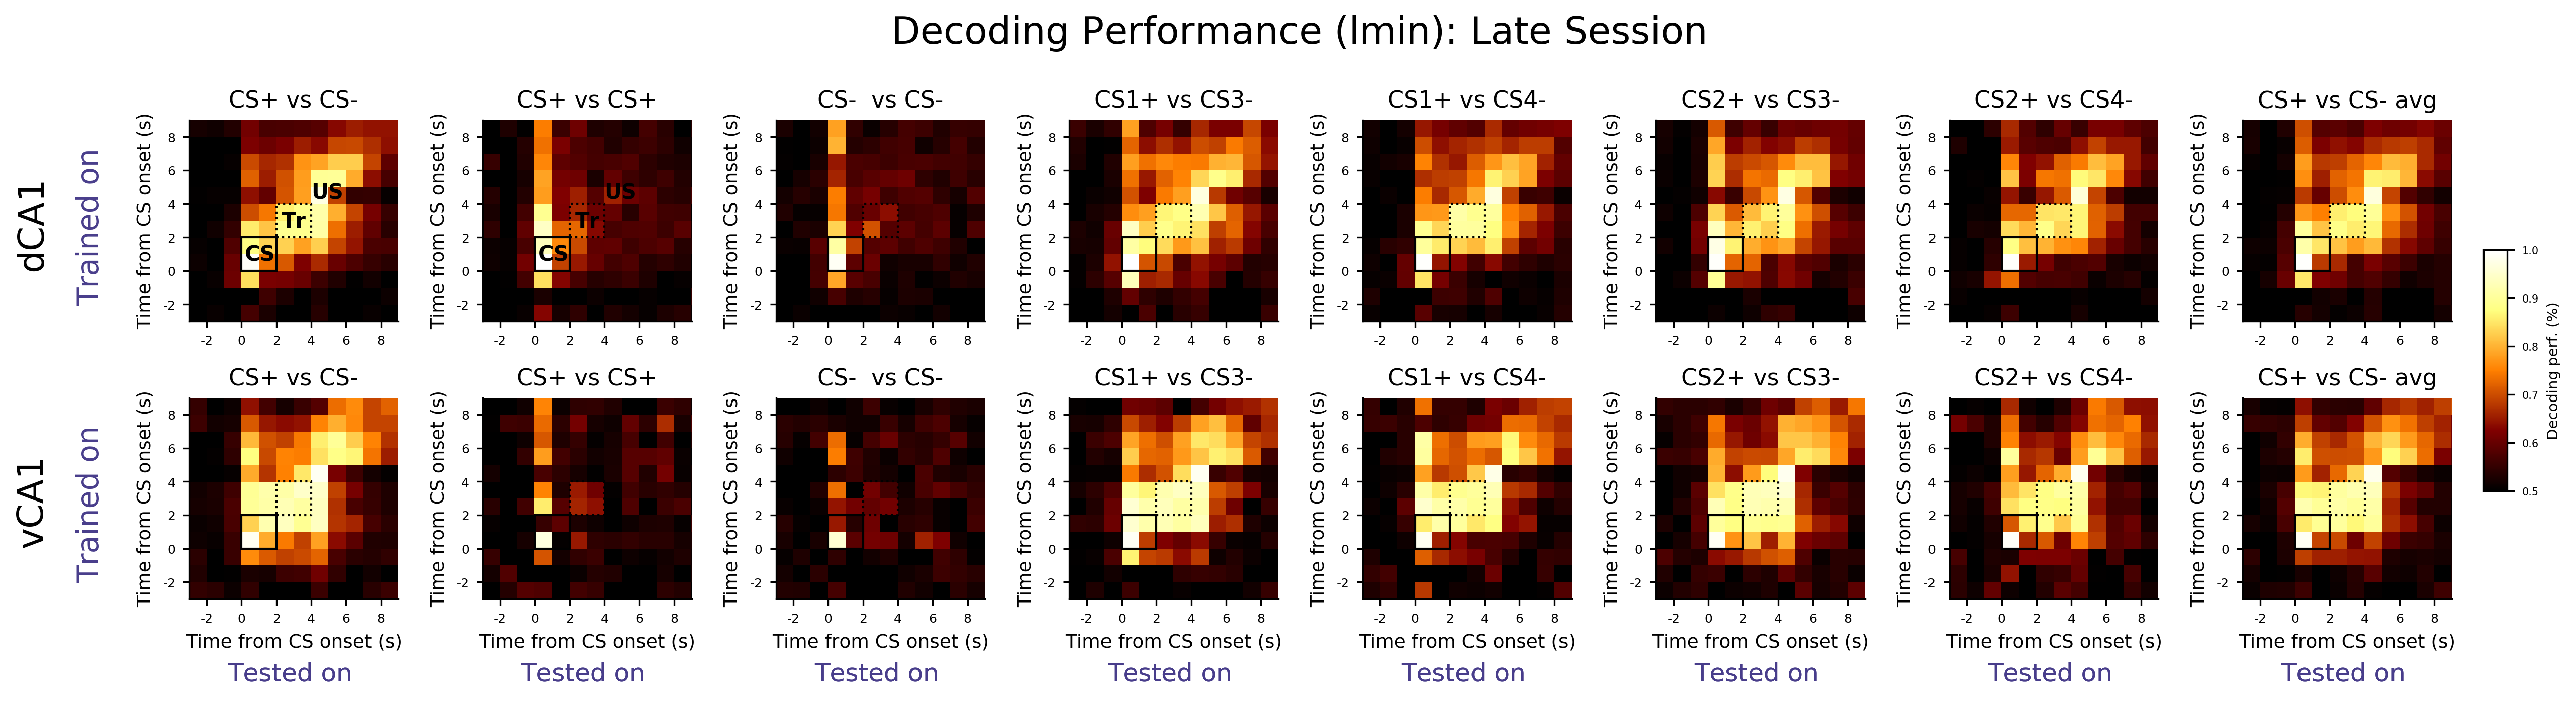

In [12]:
fig, ax = pl.subplots(2, 8, figsize=(15.7, 4))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for reg,x in zip(['dhpc','vhpc'],range(2)):
    for comp,r in zip(comparisons_av,range(len(comparisons_av))):
        im = ax[x][r].pcolormesh(eval("distinct_%s_%s['post']"%(comp,reg)),vmin=vmin, vmax=vmax,cmap='afmhot')   
        ax[x][r].set_xticks(range(1,14,2))
        ax[x][r].set_yticks(range(1,14,2))
        ax[x][r].set_ylim(2,14)
        ax[x][r].set_xlim(2,14)
        ax[x][r].set_xticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
        ax[x][r].set_yticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
        ax[x][r].set_ylabel('Time from CS onset (s)', fontsize=9)
        ax[1][r].set_xlabel('Time from CS onset (s)', fontsize=9)
        ax[x][r].set_title(comp_labels_av[r],fontsize=11,color='k')
        ax[x][r].tick_params(length=3)

import matplotlib.patches as patches
for r in range(8):
    for x in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[x][r].add_patch(CS)
        ax[x][r].add_patch(Tr)
        ax[1][r].text(4.2,-2.9,'Tested on',fontsize=12,color='darkslateblue')
for r in range(2):
    ax[r][0].text(-4.5,11,'Trained on',rotation=90,fontsize=14,color='darkslateblue')
    ax[0][r].text(5.2,5.6,"CS",fontsize=10, weight='bold', color='k')
    ax[0][r].text(7.3,7.6,"Tr",fontsize=10, weight='bold', color='k')
    ax[0][r].text(9,9.3,"US",fontsize=10, weight='bold', color='k')
    
ax[0][0].text(-8,9,'dCA1',rotation=90,fontsize=17,color='k')
ax[1][0].text(-8,9,'vCA1',rotation=90,fontsize=17,color='k')



pl.suptitle('Decoding Performance (lmin): Late Session',y=1.09,fontsize=18)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=2)
#fig.savefig('../figures/%s_across_bins_ALLcomp_late.pdf'%NOTEBOOK_NAME)

In [13]:
comparisons_av

['CSPvsCSM',
 'CS1vsCS2',
 'CS3vsCS4',
 'CS1vsCS3',
 'CS1vsCS4',
 'CS2vsCS3',
 'CS2vsCS4',
 'CSPvsCSM_averaged']

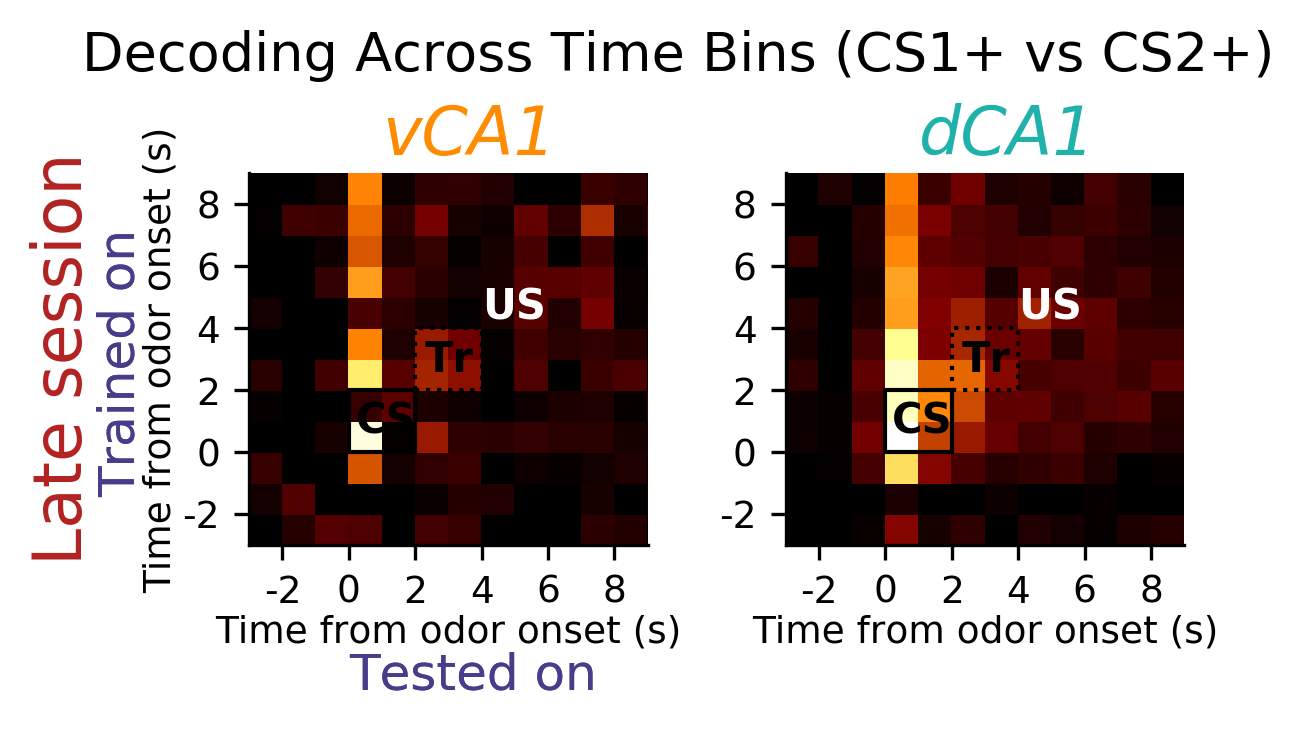

In [14]:
#import matplotlib.patches as patches

fig, ax = pl.subplots(1, 2, figsize=(3.85, 1.92))#, sharex=True, sharey=True)

for reg,c,mm,cmap,lab in zip(['vhpc','dhpc'],range(2),([.5,1],[.5,1]),['afmhot','afmhot'],['vCA1','dCA1']):
        im = ax[c].pcolormesh(eval("distinct_CS1vsCS2_%s['post']"%reg),vmin=mm[0],vmax=mm[1],cmap=cmap)
        ax[c].set_xticks(np.arange(1,14,2))
        ax[c].set_yticks(np.arange(1,14,2))
        ax[c].set_ylim(2,14)
        ax[c].set_xlim(2,14)
        ax[c].set_xticklabels(['-4','-2','0','2','4','6','8'],fontsize=9)
        ax[c].set_yticklabels(['-4','-2','0','2','4','6','8'],fontsize=9)
        ax[0].set_ylabel('Time from odor onset (s)', fontsize=9,labelpad=1)
        ax[c].set_xlabel('Time from odor onset (s)', fontsize=9,labelpad=1)
        #ax[c].set_title('Late',fontsize=12,color='firebrick')
for c in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[c].add_patch(CS)
        ax[c].add_patch(Tr)
        ax[0].text(5,-2.65,'Tested on',fontsize=12,color='darkslateblue')
for c in range(2):
    ax[0].text(-2.6,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
    ax[c].text(5.2,5.6,"CS",fontsize=10, weight='bold', color='k')
    ax[c].text(7.3,7.6,"Tr",fontsize=10, weight='bold', color='k')
    ax[c].text(9,9.3,"US",fontsize=10, weight='bold', color='w')

ax[0].text(-4.6,13,"Late session", fontsize=16, rotation=90,color='firebrick')
ax[0].text(6,14.6,"vCA1", fontsize=16,color='darkorange',style='italic')
ax[1].text(6,14.6,"dCA1", fontsize=16,color='lightseagreen',style='italic')
pl.suptitle('Decoding Across Time Bins (CS1+ vs CS2+)',y=1.15,fontsize=13)

#cax = fig.add_axes([1.03,0.3, 0.03, 0.6])
#fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=2)
fig.savefig('../figures/%s_across_bins_CS1vsCS2_late.pdf'%NOTEBOOK_NAME)

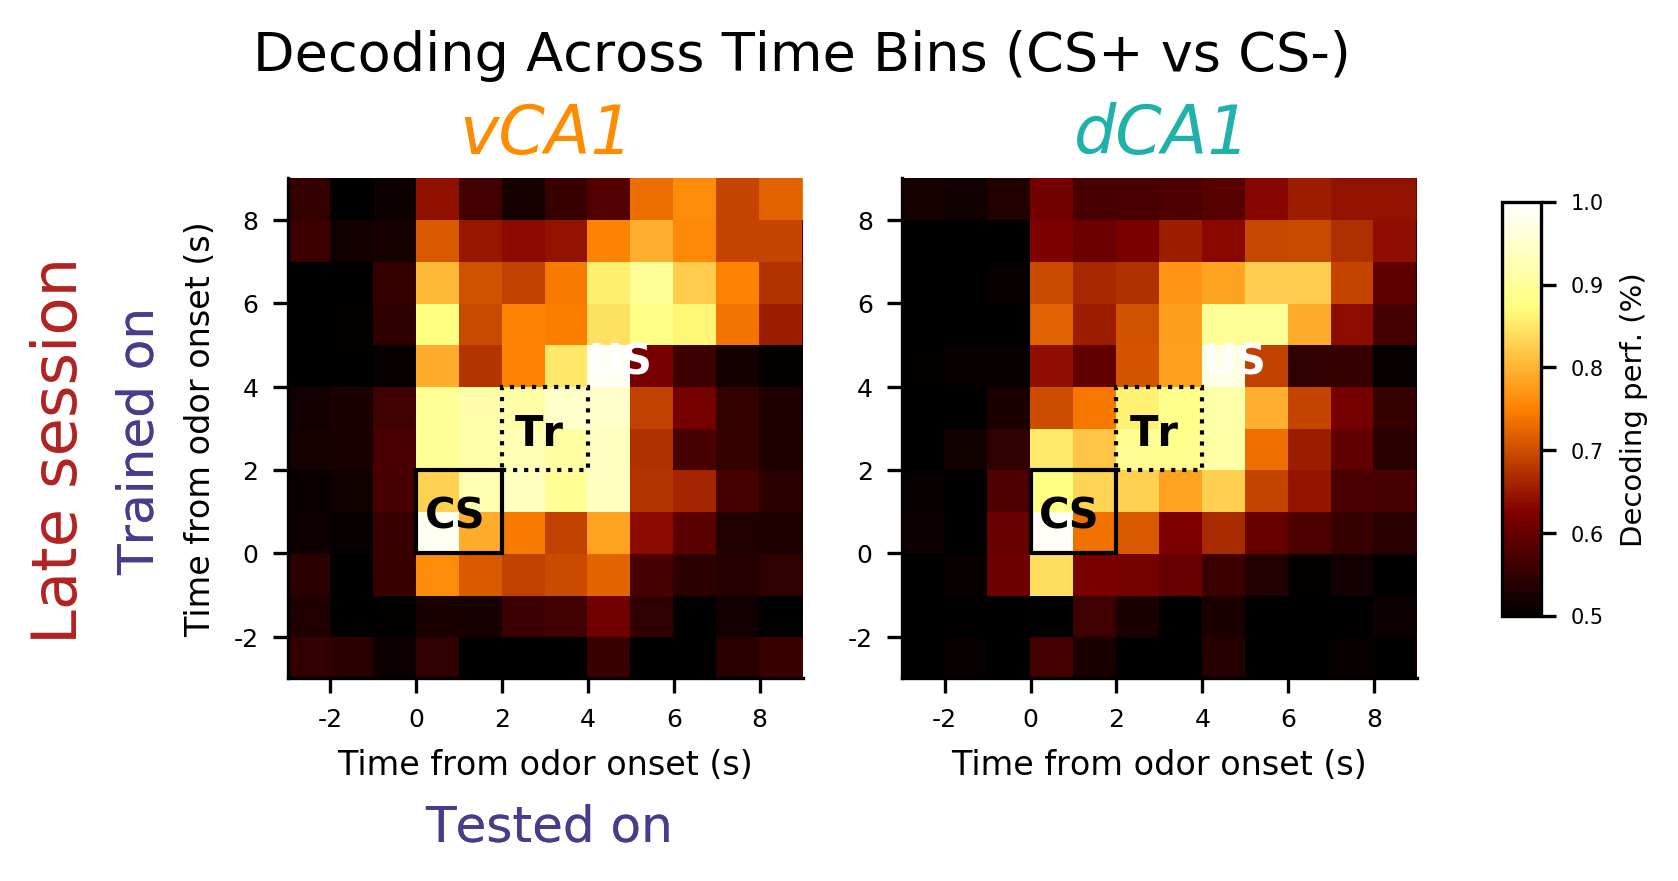

In [53]:
import matplotlib.patches as patches

fig, ax = pl.subplots(1, 2, figsize=(4.4, 2.3))#, sharex=True, sharey=True)

for reg,c,mm,cmap,lab in zip(['vhpc','dhpc'],range(2),([.5,1],[.5,1]),['afmhot','afmhot'],['vCA1','dCA1']):
        im = ax[c].pcolormesh(eval("distinct_CSPvsCSM_%s['post']"%reg),vmin=mm[0],vmax=mm[1],cmap=cmap)
        ax[c].set_xticks(np.arange(1,14,2))
        ax[c].set_yticks(np.arange(1,14,2))
        ax[c].set_ylim(2,14)
        ax[c].set_xlim(2,14)
        ax[c].set_xticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
        ax[c].set_yticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
        ax[0].set_ylabel('Time from odor onset (s)', fontsize=8)
        ax[c].set_xlabel('Time from odor onset (s)', fontsize=8)
        #ax[c].set_title('Late',fontsize=12,color='firebrick')
for c in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[c].add_patch(CS)
        ax[c].add_patch(Tr)
        ax[0].text(5.2,-1.9,'Tested on',fontsize=12,color='darkslateblue')
for c in range(2):
    ax[0].text(-2,10,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
    ax[c].text(5.2,5.6,"CS",fontsize=10, weight='bold', color='k')
    ax[c].text(7.3,7.6,"Tr",fontsize=10, weight='bold', color='k')
    ax[c].text(9,9.3,"US",fontsize=10, weight='bold', color='w')

ax[0].text(-4,11,"Late session", fontsize=15, rotation=90,color='firebrick')
ax[0].text(6,14.6,"vCA1", fontsize=16,color='darkorange',style='italic')
ax[1].text(6,14.6,"dCA1", fontsize=16,color='lightseagreen',style='italic')
pl.suptitle('Decoding Across Time Bins (CS+ vs CS-)',y=1.15,fontsize=13)

cax = fig.add_axes([1.03,0.3, 0.03, 0.6])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=2)
fig.savefig('../figures/%s_across_bins_CSPvsCSM_late.pdf'%NOTEBOOK_NAME)

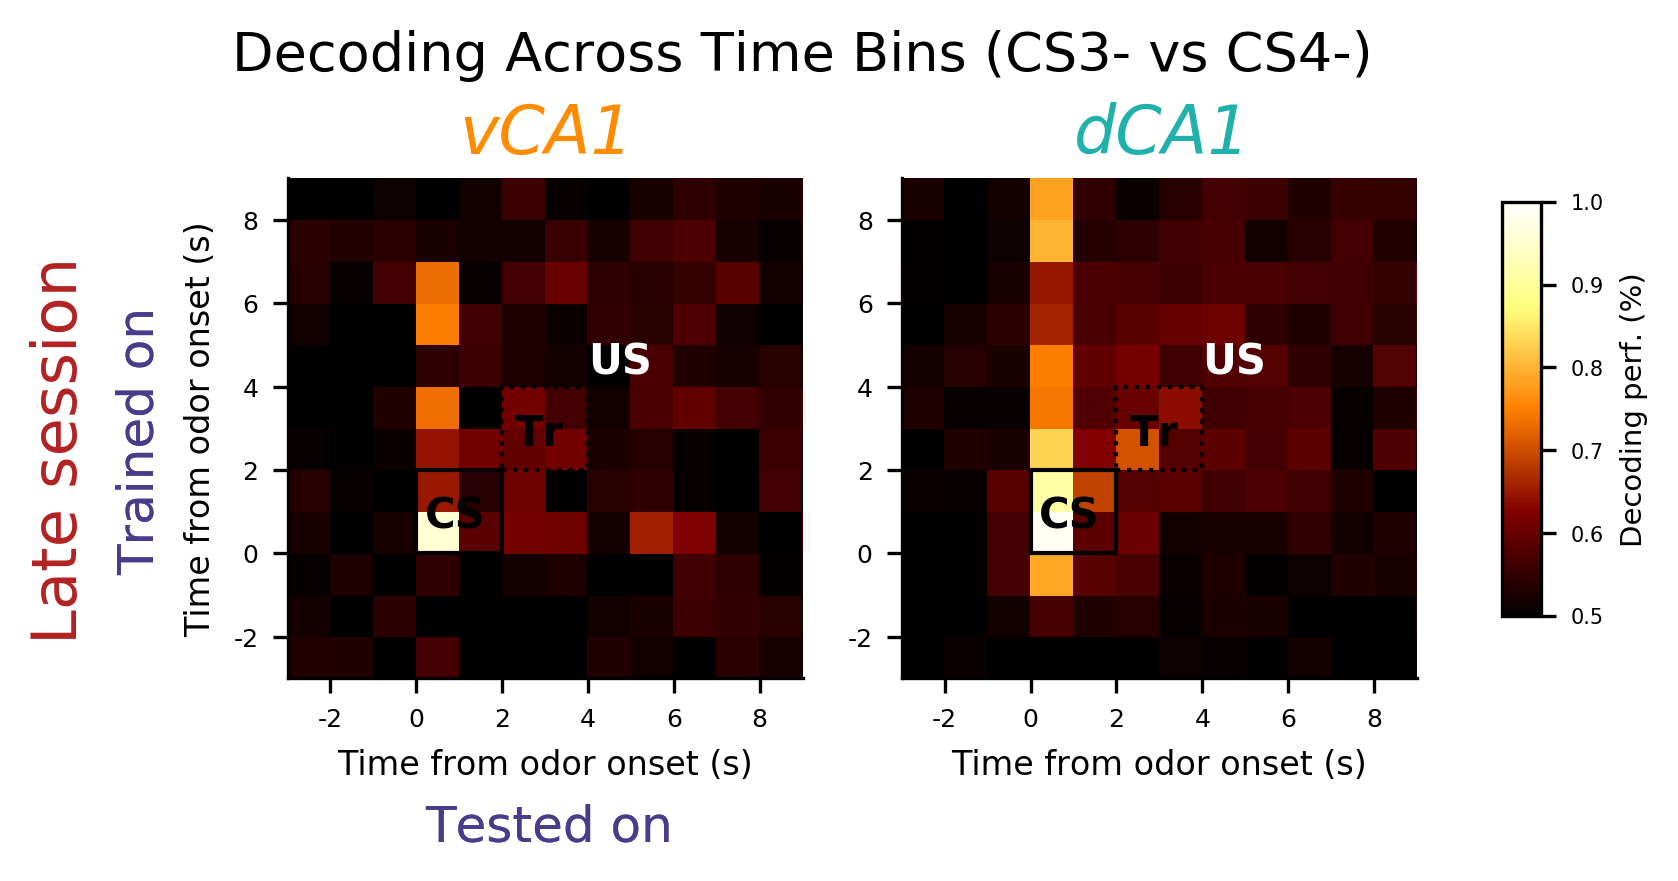

In [16]:
import matplotlib.patches as patches

fig, ax = pl.subplots(1, 2, figsize=(4.4, 2.3))#, sharex=True, sharey=True)

for reg,c,mm,cmap,lab in zip(['vhpc','dhpc'],range(2),([.5,1],[.5,1]),['afmhot','afmhot'],['vCA1','dCA1']):
        im = ax[c].pcolormesh(eval("distinct_CS3vsCS4_%s['post']"%reg),vmin=mm[0],vmax=mm[1],cmap=cmap)
        ax[c].set_xticks(np.arange(1,14,2))
        ax[c].set_yticks(np.arange(1,14,2))
        ax[c].set_ylim(2,14)
        ax[c].set_xlim(2,14)
        ax[c].set_xticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
        ax[c].set_yticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
        ax[0].set_ylabel('Time from odor onset (s)', fontsize=8)
        ax[c].set_xlabel('Time from odor onset (s)', fontsize=8)
        #ax[c].set_title('Late',fontsize=12,color='firebrick')
for c in range(2):
# Create a Rectangle patch
        CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
        Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
        ax[c].add_patch(CS)
        ax[c].add_patch(Tr)
        ax[0].text(5.2,-1.9,'Tested on',fontsize=12,color='darkslateblue')
for c in range(2):
    ax[0].text(-2,10,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
    ax[c].text(5.2,5.6,"CS",fontsize=10, weight='bold', color='k')
    ax[c].text(7.3,7.6,"Tr",fontsize=10, weight='bold', color='k')
    ax[c].text(9,9.3,"US",fontsize=10, weight='bold', color='w')

ax[0].text(-4,11,"Late session", fontsize=15, rotation=90,color='firebrick')
ax[0].text(6,14.6,"vCA1", fontsize=16,color='darkorange',style='italic')
ax[1].text(6,14.6,"dCA1", fontsize=16,color='lightseagreen',style='italic')
pl.suptitle('Decoding Across Time Bins (CS3- vs CS4-)',y=1.15,fontsize=13)

cax = fig.add_axes([1.03,0.3, 0.03, 0.6])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=2)
#fig.savefig('../figures/%s_across_bins_CS3vsCS4_late.pdf'%NOTEBOOK_NAME)

In [ ]:
#compare d/v

## now compare vhpc vs dhpc decoding

In [18]:
for r in 'dhpc','vhpc':
    for comp in comparisons_av:
        for t in range (16):
            for c in range (16):
                exec('scores_tb_distinct_%s_VS_%s_%s_%s = {}'%(t,c,comp,r))
                for sess in sessions:
                    if r == 'dhpc':
                        exec("scores_tb_distinct_%s_VS_%s_%s_%s = ut.load_variable('scores_tb_%s_VS_%s_%s',\
                         '../notebooks/autorestore/decoding_across_time_bins_%s/')"%(t,c,comp,r,t,c,comp,r))
                    if r == 'vhpc':
                        exec("scores_tb_distinct_%s_VS_%s_%s_%s = ut.load_variable('scores_tb_%s_VS_%s_%s',\
                         '../notebooks/autorestore/decoding_across_time_bins_%s/')"%(t,c,comp,r,t,c,comp,r))

In [19]:
loops=10
for comp in comparisons_av:
    for t in range (16):
        exec('distinct%s_MannWhitney_%s_dhpcVSvhpc = {}'%(t,comp))
    for sess in sessions:
        for t in range (16):
            exec("distinct%s_MannWhitney_%s_dhpcVSvhpc['%s'] = []"%(t,comp,sess))
            for c in range (16):
                eval('distinct%s_MannWhitney_%s_dhpcVSvhpc'%(t,comp))[sess].insert(c,
                      sstats.mannwhitneyu(eval('scores_tb_distinct_%s_VS_%s_%s_dhpc[sess][:loops]'%(t,c,comp)),
                      eval('scores_tb_distinct_%s_VS_%s_%s_vhpc[sess][:loops]'%(t,c,comp)), alternative='two-sided'))
            for x,i in zip(eval('distinct%s_MannWhitney_%s_dhpcVSvhpc'%(t,comp))[sess],range(len(eval('distinct%s_MannWhitney_%s_dhpcVSvhpc'%(t,comp))[sess]))):
                exec("distinct%s_MannWhitney_%s_dhpcVSvhpc[sess][i] = x[-1]"%(t,comp)) #only take p-values

In [21]:
for comp in comparisons_av:
    exec("distinct_MannWhitney_%s_dhpcVSvhpc={}"%(comp))
    for sess in sessions:
        exec("distinct_MannWhitney_%s_dhpcVSvhpc[sess]=(distinct0_MannWhitney_%s_dhpcVSvhpc[sess], distinct1_MannWhitney_%s_dhpcVSvhpc[sess], distinct2_MannWhitney_%s_dhpcVSvhpc[sess], distinct3_MannWhitney_%s_dhpcVSvhpc[sess],\
              distinct4_MannWhitney_%s_dhpcVSvhpc[sess], distinct5_MannWhitney_%s_dhpcVSvhpc[sess], distinct6_MannWhitney_%s_dhpcVSvhpc[sess], distinct7_MannWhitney_%s_dhpcVSvhpc[sess],\
              distinct8_MannWhitney_%s_dhpcVSvhpc[sess], distinct9_MannWhitney_%s_dhpcVSvhpc[sess], distinct10_MannWhitney_%s_dhpcVSvhpc[sess], distinct11_MannWhitney_%s_dhpcVSvhpc[sess],\
              distinct12_MannWhitney_%s_dhpcVSvhpc[sess], distinct13_MannWhitney_%s_dhpcVSvhpc[sess],distinct14_MannWhitney_%s_dhpcVSvhpc[sess],\
              distinct15_MannWhitney_%s_dhpcVSvhpc[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_MannWhitney_%s_dhpcVSvhpc[sess]"%(comp))])

### code so we can visualize which region had better decoding for each significant bin

In [22]:
import copy
for comp in comparisons_av:
    exec("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot = copy.deepcopy(distinct_MannWhitney_%s_dhpcVSvhpc)"%(comp,comp))

In [132]:
##code time bins as sig with vhpc higher(-1), dhpc higher(1), or not significant(0)
#for comp in comparisons_av:
#    for sess in sessions:
#        for i in range(len(distinct_CSPvsCSM_vhpc[sess])):
#            for j in range(len(distinct_CSPvsCSM_vhpc[sess][i])):
#                exec("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot[sess][i][j]=0"%(comp))
#                if eval("distinct_%s_vhpc[sess][i][j]"%comp) > eval("distinct_%s_dhpc[sess][i][j] and distinct_MannWhitney_%s_dhpcVSvhpc[sess][i][j]"%(comp,comp)) < 0.05:
#                    exec("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot[sess][i][j]=-1"%(comp))
#                if eval("distinct_%s_vhpc[sess][i][j]"%comp) < eval("distinct_%s_dhpc[sess][i][j] and distinct_MannWhitney_%s_dhpcVSvhpc[sess][i][j]"%(comp,comp)) < 0.05:
#                    exec("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot[sess][i][j]=1"%(comp))
#                #else:
#                #    distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0

In [23]:
import math
for comp in comparisons_av:
    for sess in sessions:
        for i in range(len(distinct_CSPvsCSM_vhpc[sess])):
            for j in range(len(distinct_CSPvsCSM_vhpc[sess][i])):
                exec("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot[sess][i][j]=0"%(comp))
                if eval("distinct_%s_vhpc[sess][i][j]"%comp) > eval("distinct_%s_dhpc[sess][i][j]"%comp) and eval("distinct_MannWhitney_%s_dhpcVSvhpc[sess][i][j]"%comp) < 0.05:
                    exec("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot[sess][i][j]=(math.log10(distinct_MannWhitney_%s_dhpcVSvhpc[sess][i][j]))"%(comp,comp))
                if eval("distinct_%s_vhpc[sess][i][j]"%comp) < eval("distinct_%s_dhpc[sess][i][j]"%comp) and eval("distinct_MannWhitney_%s_dhpcVSvhpc[sess][i][j]"%comp) < 0.05:
                    exec("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot[sess][i][j]=-(math.log10(distinct_MannWhitney_%s_dhpcVSvhpc[sess][i][j]))"%(comp,comp))
                #else:
                #    distinct_MannWhitney_dhpcVSvhpc_to_plot[sess][i][j]=0

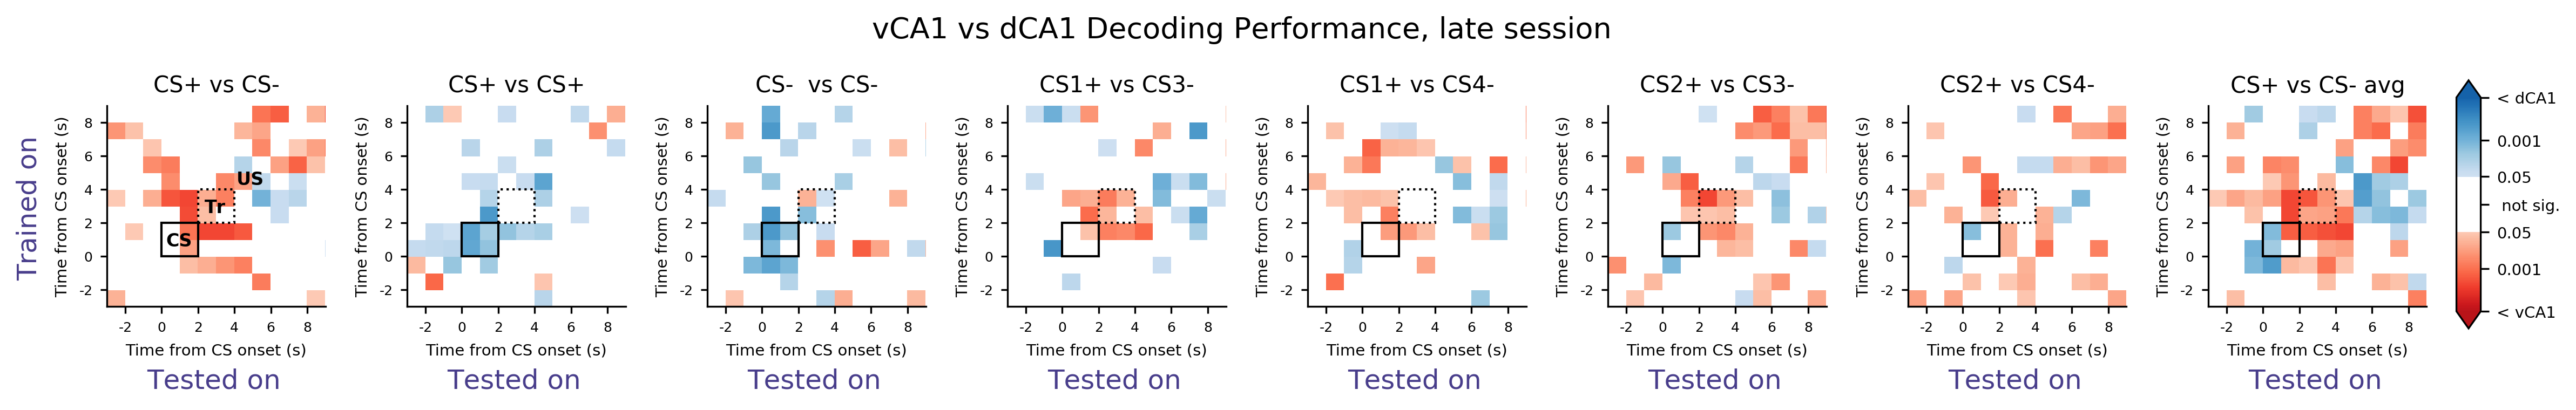

In [27]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
dsigs = cm.get_cmap('Blues', 80)
vsigs = cm.get_cmap('Reds', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.8, 0, 128)),
                       dsigs(np.linspace(0, .8, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 8, figsize=(15, 2.1))#, sharex=True, sharey=True)
vmin=-5
vmax=5
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].pcolormesh(eval("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot['post']"%comp),vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(1,14,2))
    ax[x].set_yticks(range(1,14,2))
    ax[x].set_ylim(2,14)
    ax[x].set_xlim(2,14)
    ax[x].set_xticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
    ax[x].set_yticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.9,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-3,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(5.25,5.6,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(7.35,7.6,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(9.1,9.3,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('vCA1 vs dCA1 Decoding Performance, late session',y=1.09,fontsize=13)

cax = fig.add_axes([1,0.17, 0.01, 0.73])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.08)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=7)
fig.tight_layout(pad=2.5)

fig.savefig('../figures/%s_gmin_across_bins_dVSv_Utest_late.pdf'%NOTEBOOK_NAME)

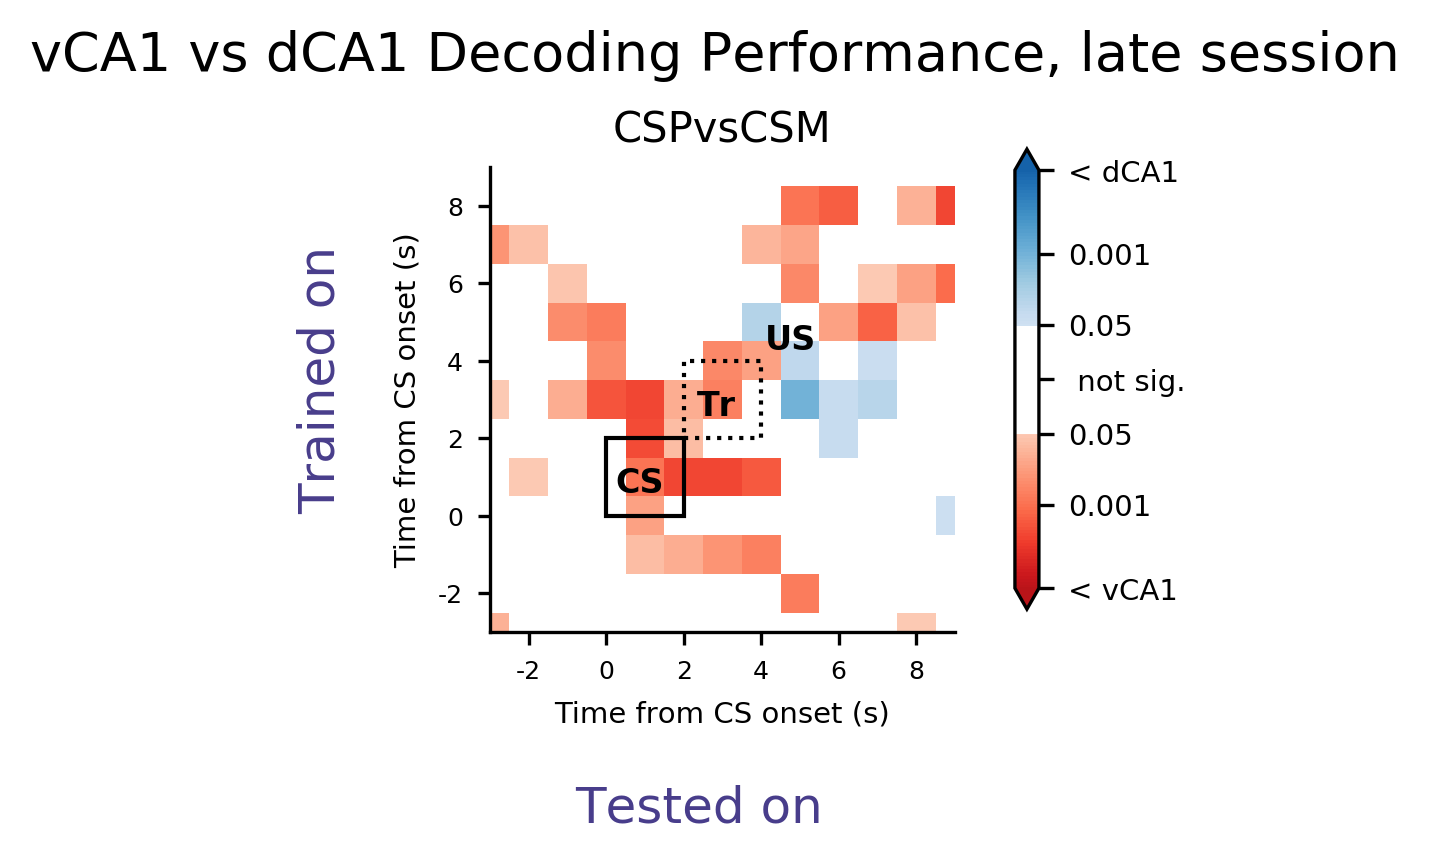

In [50]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
dsigs = cm.get_cmap('Blues', 80)
vsigs = cm.get_cmap('Reds', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.8, 0, 128)),
                       dsigs(np.linspace(0, .8, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 1, figsize=(2, 2.1))#, sharex=True, sharey=True)
vmin=-5
vmax=5
comp='CSPvsCSM'
x=0
im = ax.imshow(eval("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot['post']"%comp),vmin=vmin, vmax=vmax,cmap=newcmap)
ax.set_xticks(range(1,14,2))
ax.set_yticks(range(1,14,2))
ax.set_ylim(2,14)
ax.set_xlim(2,14)
ax.set_xticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
ax.set_yticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
ax.set_ylabel('Time from CS onset (s)', fontsize=7)
ax.set_xlabel('Time from CS onset (s)', fontsize=7)
ax.set_title(comp,fontsize=10,color='k')
ax.tick_params(length=3)

import matplotlib.patches as patches
# Create a Rectangle patch
CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
ax.add_patch(CS)
ax.add_patch(Tr)
ax.text(4.2,-2.9,'Tested on',fontsize=12,color='darkslateblue')

ax.text(-3,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax.text(5.25,5.6,"CS",fontsize=8, weight='bold', color='k')
ax.text(7.35,7.6,"Tr",fontsize=8, weight='bold', color='k')
ax.text(9.1,9.3,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('vCA1 vs dCA1 Decoding Performance, late session',y=1.09,fontsize=13)

cax = fig.add_axes([1,0.17, 0.04, 0.73])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.05)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=7)

fig.savefig('../figures/%s_gmin_across_bins_dVSv_Utest_late.pdf'%NOTEBOOK_NAME)

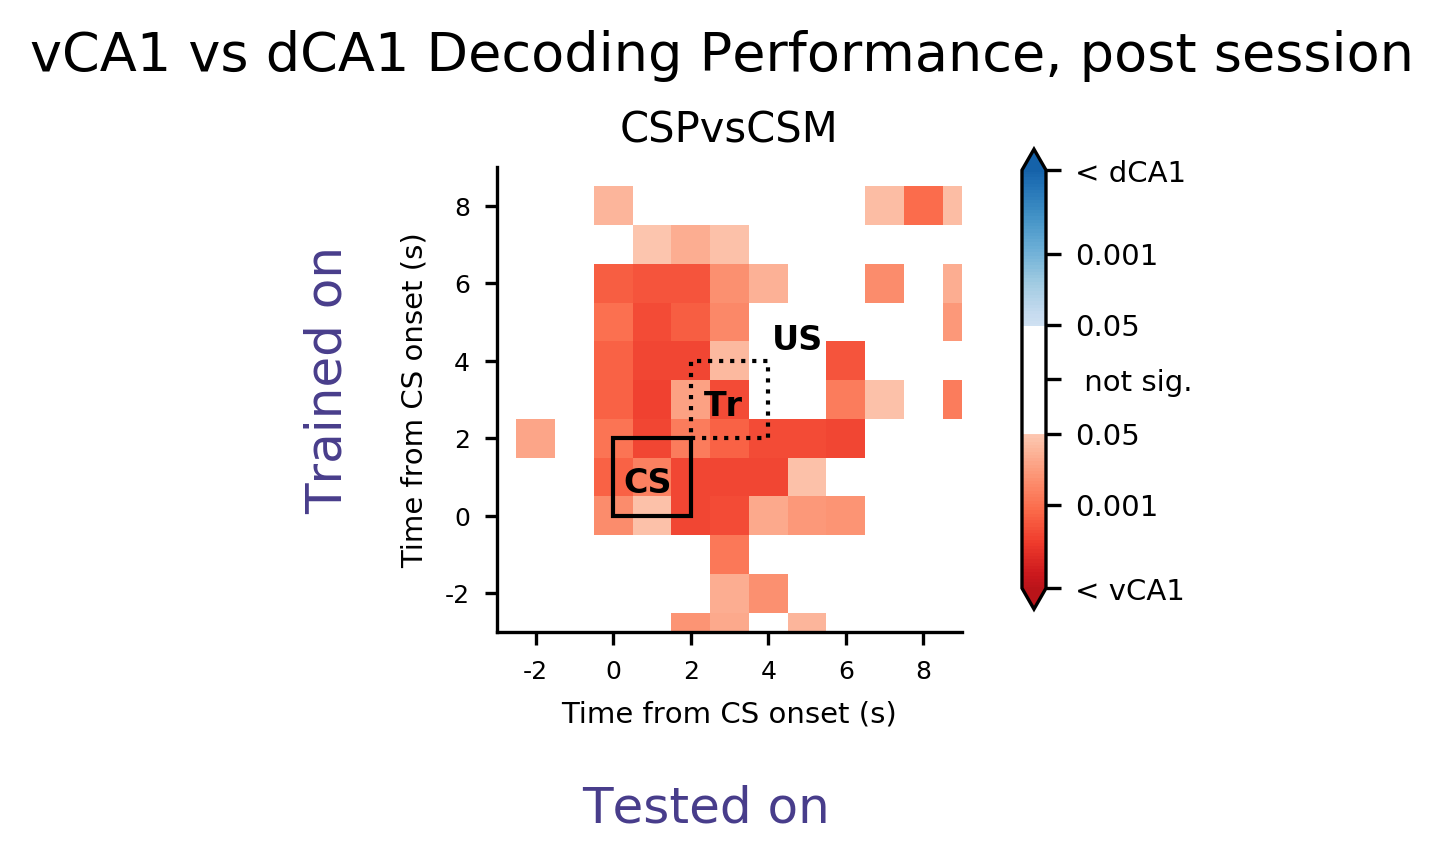

In [54]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
dsigs = cm.get_cmap('Blues', 80)
vsigs = cm.get_cmap('Reds', 80)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((vsigs(np.linspace(.8, 0, 128)),
                       dsigs(np.linspace(0, .8, 128))))
#pink = np.array([.96, .09, .6, 1])
newcolors[95:161, :] = white
newcmap = ListedColormap(newcolors)


fig, ax = pl.subplots(1, 1, figsize=(2, 2.1))#, sharex=True, sharey=True)
vmin=-5
vmax=5
comp='CSPvsCSM'
x=0
im = ax.imshow(eval("distinct_MannWhitney_%s_dhpcVSvhpc_to_plot['post_hiatus']"%comp),vmin=vmin, vmax=vmax,cmap=newcmap)
ax.set_xticks(range(1,14,2))
ax.set_yticks(range(1,14,2))
ax.set_ylim(2,14)
ax.set_xlim(2,14)
ax.set_xticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
ax.set_yticklabels(['-4','-2','0','2','4','6','8'],fontsize=6)
ax.set_ylabel('Time from CS onset (s)', fontsize=7)
ax.set_xlabel('Time from CS onset (s)', fontsize=7)
ax.set_title(comp,fontsize=10,color='k')
ax.tick_params(length=3)

import matplotlib.patches as patches
# Create a Rectangle patch
CS = patches.Rectangle((5,5),2,2,linewidth=1,edgecolor='k',facecolor='none')
Tr = patches.Rectangle((7,7),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
ax.add_patch(CS)
ax.add_patch(Tr)
ax.text(4.2,-2.9,'Tested on',fontsize=12,color='darkslateblue')

ax.text(-3,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax.text(5.25,5.6,"CS",fontsize=8, weight='bold', color='k')
ax.text(7.35,7.6,"Tr",fontsize=8, weight='bold', color='k')
ax.text(9.1,9.3,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('vCA1 vs dCA1 Decoding Performance, post session',y=1.09,fontsize=13)

cax = fig.add_axes([1,0.17, 0.04, 0.73])
cbar = fig.colorbar(im, cax=cax,ticks=[-5,-3,-1.3,0,1.3,3,5],extend='both',extendfrac=.05)
cbar.ax.set_yticklabels(['< vCA1', '0.001','0.05', ' not sig.', '0.05','0.001','< dCA1'],fontsize=7)

fig.savefig('../figures/%s_gmin_across_bins_dVSv_Utest_post.pdf'%NOTEBOOK_NAME)

# left off here

In [26]:
save_workspace(db)

Could not store variable 'copy'. Skipping...
Could not store variable 'patches'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'cm'. Skipping...
Could not store variable 'math'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
